In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import os
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")

# Preparing Data

## Create SparkSession

In [7]:
# spark = SparkSession.builder.appName("NYC_ETA").config("spark.some.config.option", "some-value").getOrCreate()

In [8]:
spark = SparkSession.builder \
    .appName("NYC_ETA") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.memory.offHeap.size","8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()


## Read Parquet Files

In [9]:
# Merge all data parquet files

jul_data_path = "../data/yellow_tripdata_2024-07.parquet"
aug_data_path = "../data/yellow_tripdata_2024-08.parquet"
sep_data_path = "../data/yellow_tripdata_2024-09.parquet"
df_jul = spark.read.parquet(jul_data_path)
df_aug = spark.read.parquet(aug_data_path)
df_sep = spark.read.parquet(sep_data_path)

df = df_jul.union(df_aug).union(df_sep)

output_path = "../data/merged_yellow_tripdata_2024_Q3.parquet"
# df.write.parquet(output_path)

df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2024-07-01 00:34:56|  2024-07-01 00:46:49|              1|          3.2|         1|                 N|         140|          79|           1|       15.6|  3.5|    0.5|       3.

In [10]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



![data_schema.png](./data_schema.png)

### Merge Taxi Zone Data

In [11]:
zones_df = spark.read.csv("../data/taxi_zone_lookup.csv", header=True, inferSchema=True)
zones_df.show(5)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows



#### Merge **zones_df** with **df** by **Pick Up Location**

In [12]:
df = df.join(zones_df, df.PULocationID == zones_df.LocationID, "inner")

df = df \
    .withColumnRenamed("Borough", "PU_Borough") \
    .withColumnRenamed("Zone", "PU_Zone") \
    .withColumnRenamed("service_zone", "PU_service_zone")

df = df.drop("LocationID")

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|PU_Borough|             PU_Zone|PU_service_zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+
|       1| 2024-07-01 00:34:56|  2024-07-01

#### Merge **zones_df** with **df** by **Drop Off Location**

In [13]:
df = df.join(zones_df, df.DOLocationID == zones_df.LocationID, "inner")

df = df \
    .withColumnRenamed("Borough", "DO_Borough") \
    .withColumnRenamed("Zone", "DO_Zone") \
    .withColumnRenamed("service_zone", "DO_service_zone")

df = df.drop("LocationID")

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+----------+--------------------+---------------+----------+--------------------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|PU_Borough|             PU_Zone|PU_service_zone|DO_Borough|             DO_Zone|DO_service_zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------

#### Drop some irrelevant columns which has no or little impact in estimate time arrival

In [14]:
columns_to_drop = [
    "store_and_fwd_flag", 
    "payment_type", 
    "fare_amount", 
    "extra", 
    "mta_tax", 
    "tip_amount", 
    "tolls_amount", 
    "improvement_surcharge", 
    "total_amount", 
    "PU_service_zone", 
    "DO_service_zone"
]

df = df.drop(*columns_to_drop)

df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+-----------+----------+--------------------+----------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|congestion_surcharge|Airport_fee|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+-----------+----------+--------------------+----------+--------------------+
|       1| 2024-07-01 00:34:56|  2024-07-01 00:46:49|              1|          3.2|         1|         140|          79|                 2.5|        0.0| Manhattan|     Lenox Hill East| Manhattan|        East Village|
|       2| 2024-06-30 23:48:58|  2024-07-01 00:28:04|              1|        19.48|         2|         132|         113|        

# Preprocessing Data

## Data Cleaning

#### trip_distance


In [15]:
from pyspark.sql.functions import col, mean as spark_mean, stddev

# Calculate mean and standard deviation
trip_dis_stats = df.select(
    spark_mean(col("trip_distance")).alias("mean"),
    stddev(col("trip_distance")).alias("stddev")
).collect()[0]
trip_dis_stats

Row(mean=5.296567671395089, stddev=433.93545298571394)

In [16]:
trip_dis_mean = trip_dis_stats["mean"]
trip_dis_stddev = trip_dis_stats["stddev"]

print(f"Mean for Trip Duration is: {trip_dis_mean}")
print(f"Standard Deviation for Trip Duration is: {trip_dis_stddev}")

# Filter rows within 2 standard deviations
df = df.filter(
    (col("trip_distance") >= trip_dis_mean - 2 * trip_dis_stddev) &
    (col("trip_distance") <= trip_dis_mean + 2 * trip_dis_stddev) &
    (col("trip_distance") >= 1)
)

df.describe().show()

Mean for Trip Duration is: 5.296567671395089
Standard Deviation for Trip Duration is: 433.93545298571394


24/12/09 11:05:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/09 11:05:22 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+----------+--------------------+----------+--------------------+
|summary|          VendorID|   passenger_count|     trip_distance|        RatecodeID|      PULocationID|     DOLocationID|congestion_surcharge|        Airport_fee|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+----------+--------------------+----------+--------------------+
|  count|           7463340|           6606139|           7463340|           6606139|           7463340|          7463340|             6606139|            6606139|   7463340|             7463340|   7463340|             7463340|
|   mean| 1.770373452100534|1.3486086199518357|4.4061404505223205|2.7390846604953363|160

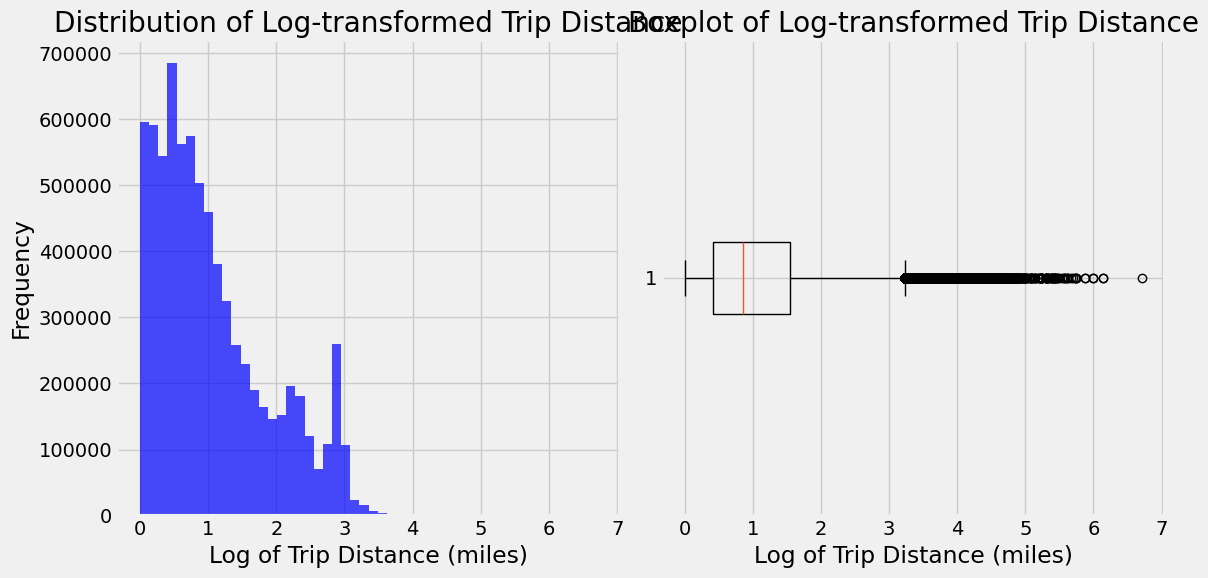

In [17]:
trip_distance_data = df.select("trip_distance").toPandas()

trip_distance_data = trip_distance_data[trip_distance_data['trip_distance'] > 0]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(np.log(trip_distance_data['trip_distance']), bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Log-transformed Trip Distance')
plt.xlabel('Log of Trip Distance (miles)')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(np.log(trip_distance_data['trip_distance']), vert=False)
plt.title('Boxplot of Log-transformed Trip Distance')
plt.xlabel('Log of Trip Distance (miles)')
plt.grid(True)

plt.tight_layout()
plt.show()


#### passenger_count

Filter rows where `passenger_count` is 7, 8, 9 or 0 because it is uncommon in NYC taxi data
> *(most taxis accommodate up to 6 passengers)*

In [18]:
from pyspark.sql.functions import col
df = df.filter(~(col("passenger_count").isin([7, 8, 9, 0])))

##### airport_fee to enter_airport

In [19]:
from pyspark.sql.functions import when

df = df.withColumn(
    "enter_airport", 
    when(col("airport_fee") > 0, 1).otherwise(0)
)
df.select("enter_airport").show(5)


+-------------+
|enter_airport|
+-------------+
|            0|
|            1|
|            0|
|            1|
|            0|
+-------------+
only showing top 5 rows



In [20]:
df = df.drop("airport_fee")

##### pick_up and drop_off datetime

In [21]:
from pyspark.sql.functions import to_timestamp

df = df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime", "yyyy-MM-dd HH:mm:ss")) \
       .withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "yyyy-MM-dd HH:mm:ss"))

df.select("tpep_pickup_datetime", "tpep_dropoff_datetime").show(truncate=False)


+--------------------+---------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|
+--------------------+---------------------+
|2024-07-01 07:34:56 |2024-07-01 07:46:49  |
|2024-07-01 06:48:58 |2024-07-01 07:28:04  |
|2024-07-01 07:23:18 |2024-07-01 07:29:51  |
|2024-07-01 07:07:55 |2024-07-01 07:34:34  |
|2024-07-01 07:19:42 |2024-07-01 07:32:13  |
|2024-07-01 07:34:04 |2024-07-01 07:43:13  |
|2024-07-01 07:59:52 |2024-07-01 08:05:27  |
|2024-07-01 07:13:50 |2024-07-01 07:28:03  |
|2024-07-01 07:43:34 |2024-07-01 08:01:43  |
|2024-07-01 07:52:25 |2024-07-01 08:17:53  |
|2024-07-01 07:51:18 |2024-07-01 08:01:42  |
|2024-07-01 07:33:24 |2024-07-01 07:54:44  |
|2024-07-01 07:56:52 |2024-07-01 08:12:59  |
|2024-07-01 07:36:26 |2024-07-01 07:50:42  |
|2024-07-01 07:59:32 |2024-07-01 08:07:58  |
|2024-07-01 07:16:06 |2024-07-01 07:45:42  |
|2024-07-01 07:56:04 |2024-07-01 08:13:10  |
|2024-07-01 07:18:04 |2024-07-01 07:49:00  |
|2024-07-01 07:09:49 |2024-07-01 07:36:44  |
|2024-07-0

`tpep_pickup_datetime`

In [22]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

df = df.withColumn("pickup_date", F.to_date(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_hour", F.hour(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_minute", F.minute(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_second", F.second(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_weekday", F.dayofweek(F.col("tpep_pickup_datetime")) - 1)  # Adjust to 0-based (Sunday: 0, Monday: 1,...)
df = df.withColumn("pickup_month", F.month(F.col("tpep_pickup_datetime")))
df = df.withColumn("pickup_day", F.day(F.col("tpep_pickup_datetime")))


# Weekly hour feature (captures patterns based on the time of day and the day of the week)
df = df.withColumn(
    "pickup_week_hour", F.col("pickup_weekday") * 24 + F.col("pickup_hour")  # 0 (Sunday midnight) to 167 (Saturday 11:00 PM)
)

df = df.withColumn(
    "pickup_time", 
    F.concat(
        F.lpad(F.col("pickup_hour"), 2, "0"), F.lit(":"),
        F.lpad(F.col("pickup_minute"), 2, "0"), F.lit(":"),
        F.lpad(F.col("pickup_second"), 2, "0")
    )
)

`tpep_dropoff_datetime`

In [23]:
df = df.withColumn("dropoff_date", F.to_date(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_hour", F.hour(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_minute", F.minute(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_second", F.second(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_weekday", F.dayofweek(F.col("tpep_dropoff_datetime")) - 1)  # Adjust to 0-based (Sunday: 0, Monday: 1,...)
df = df.withColumn("dropoff_month", F.month(F.col("tpep_dropoff_datetime")))
df = df.withColumn("dropoff_day", F.day(F.col("tpep_dropoff_datetime")))

df = df.withColumn(
    "dropoff_time", 
    F.concat(
        F.lpad(F.col("dropoff_hour"), 2, "0"), F.lit(":"),
        F.lpad(F.col("dropoff_minute"), 2, "0"), F.lit(":"),
        F.lpad(F.col("dropoff_second"), 2, "0")
    )
)

df.select(
    "pickup_date", "pickup_time" , "pickup_month", "pickup_day", "pickup_weekday", "pickup_hour", "pickup_minute", "pickup_second", 
    "pickup_week_hour", "dropoff_date", "dropoff_time" , "dropoff_month", "dropoff_day", "dropoff_hour", "dropoff_minute", "dropoff_second"
).show(truncate=False)


+-----------+-----------+------------+----------+--------------+-----------+-------------+-------------+----------------+------------+------------+-------------+-----------+------------+--------------+--------------+
|pickup_date|pickup_time|pickup_month|pickup_day|pickup_weekday|pickup_hour|pickup_minute|pickup_second|pickup_week_hour|dropoff_date|dropoff_time|dropoff_month|dropoff_day|dropoff_hour|dropoff_minute|dropoff_second|
+-----------+-----------+------------+----------+--------------+-----------+-------------+-------------+----------------+------------+------------+-------------+-----------+------------+--------------+--------------+
|2024-07-01 |07:34:56   |7           |1         |1             |7          |34           |56           |31              |2024-07-01  |07:46:49    |7            |1          |7           |46            |49            |
|2024-07-01 |06:48:58   |7           |1         |1             |6          |48           |58           |30              |2024-07-01 

In [38]:
df = df.withColumn(
    "trip_duration_seconds", 
    (F.unix_timestamp("tpep_dropoff_datetime") - F.unix_timestamp("tpep_pickup_datetime")) 
)
df = df.filter(col("trip_duration_seconds") <= 72000)

df.select("trip_duration_seconds").show(5)


+---------------------+
|trip_duration_seconds|
+---------------------+
|                  713|
|                 2346|
|                  393|
|                 1599|
|                  751|
+---------------------+
only showing top 5 rows



In [39]:
df = df.withColumn("trip_duration_minutes",col("trip_duration_seconds")/60)
df.select("trip_duration_seconds","trip_duration_minutes").show(5)

+---------------------+---------------------+
|trip_duration_seconds|trip_duration_minutes|
+---------------------+---------------------+
|                  713|   11.883333333333333|
|                 2346|                 39.1|
|                  393|                 6.55|
|                 1599|                26.65|
|                  751|   12.516666666666667|
+---------------------+---------------------+
only showing top 5 rows



In [40]:
df = df.drop("trip_duration_seconds")

#### speed in miles per hour

In [41]:
df = df.withColumn("speed_mph", F.col("trip_distance") / (F.col("trip_duration_minutes") / 60))
min_speed = 0
max_speed = 100

df = df.filter((F.col("speed_mph") >= min_speed) & (F.col("speed_mph") <= max_speed))
df.select("speed_mph").describe().show(5)

+-------+--------------------+
|summary|           speed_mph|
+-------+--------------------+
|  count|             6539368|
|   mean|  12.108285492836272|
| stddev|  6.9359989112134555|
|    min|0.056768743400211194|
|    max|               100.0|
+-------+--------------------+



#### Remove rows with IQR of speed

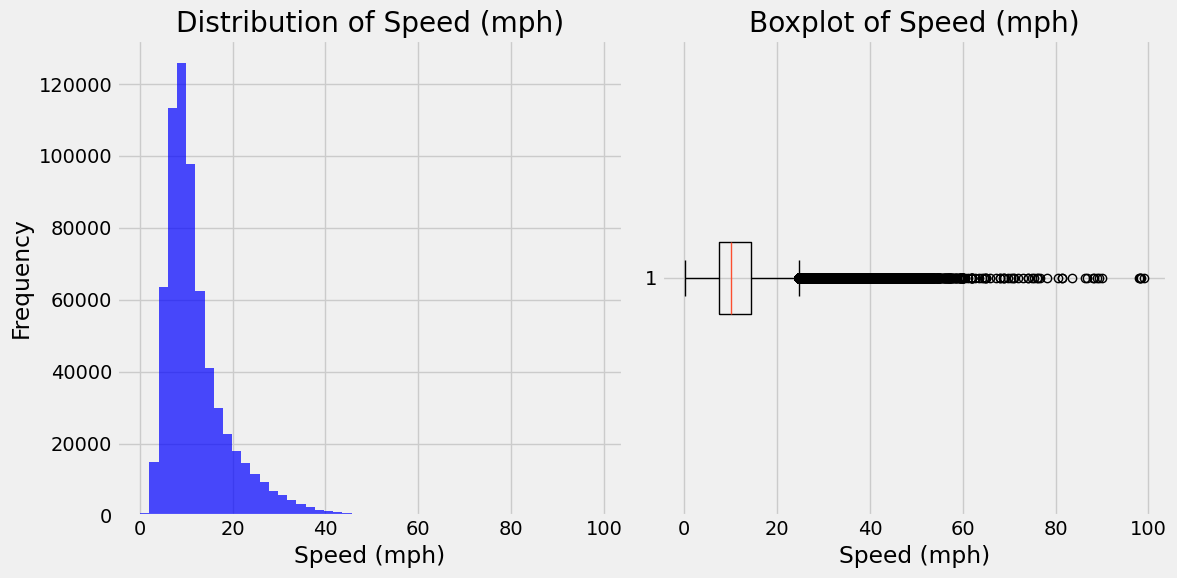

In [42]:
# Convert the speed_mph column to a pandas DataFrame for visualization
speed_data = df.select("speed_mph").sample(fraction=0.1, seed=42).toPandas()

# Plot the distribution of speed
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(speed_data['speed_mph'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Speed (mph)')
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.grid(True)

# Plot the boxplot of speed
plt.subplot(1, 2, 2)
plt.boxplot(speed_data['speed_mph'], vert=False)
plt.title('Boxplot of Speed (mph)')
plt.xlabel('Speed (mph)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [43]:
# Calculate the IQR for speed_mph
Q1_speed = df.approxQuantile("speed_mph", [0.25], 0.05)[0]
Q3_speed = df.approxQuantile("speed_mph", [0.75], 0.05)[0]
IQR_speed = Q3_speed - Q1_speed

# Define the lower and upper bounds for outliers
lower_bound_speed = Q1_speed - 1.5 * IQR_speed
upper_bound_speed = Q3_speed + 1.5 * IQR_speed

# Filter the dataframe to remove outliers
df = df.filter((col("speed_mph") >= lower_bound_speed) & (col("speed_mph") <= upper_bound_speed))

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+-----------+------------+------------+--------------+--------------+---------------+-------------+-----------+------------+------------------+---------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|congestion_surcharge|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|pickup_time|dropoff_date|dropoff_hour|dropoff_minute|dropoff_second|dropoff_weekday|dropoff_month|dropoff_day|dropoff_time|         speed_mph|trip_duration_minutes|
+--------+------

#### Visualize the Total trip duration throughout a day every day in July

In [44]:
july_data = df.filter(F.col("pickup_month") == 7)

july_data = july_data.groupBy("pickup_day").agg(
    F.sum("trip_duration_seconds").alias("total_trip_duration_seconds"),
    F.count("pickup_day").alias("trip_count")
)

july_data = july_data.orderBy("pickup_day")

pandas_july_data = july_data.toPandas()

plt.figure(figsize=(10, 5))

plt.plot(pandas_july_data['pickup_day'], pandas_july_data['total_trip_duration_seconds'], linestyle='-', marker='o', color='b', alpha=0.6)

plt.title('Total Trip Duration in July by Day of the Month', fontsize=12)
plt.xlabel('Day of the Month', fontsize=8)
plt.ylabel('Total Trip Duration (Seconds)', fontsize=8)

plt.grid(True)
plt.tight_layout()
plt.show()


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `trip_duration_seconds` cannot be resolved. Did you mean one of the following? [`trip_duration_minutes`, `dropoff_second`, `pickup_second`, `trip_distance`, `DOLocationID`].;
'Aggregate [pickup_day#2560], [pickup_day#2560, sum('trip_duration_seconds) AS total_trip_duration_seconds#3909, count(pickup_day#2560) AS trip_count#3911L]
+- Filter (pickup_month#2539 = 7)
   +- Filter ((speed_mph#3513 >= -2.3861753333859337) AND (speed_mph#3513 <= 23.8390278544938))
      +- Filter ((speed_mph#3513 >= cast(0 as double)) AND (speed_mph#3513 <= cast(100 as double)))
         +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
            +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
               +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 10 more fields]
                  +- Filter (trip_duration_seconds#3392L <= cast(72000 as bigint))
                     +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
                        +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 8 more fields]
                           +- Filter ((speed_mph#3212 >= cast(0 as double)) AND (speed_mph#3212 <= cast(100 as double)))
                              +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
                                 +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 8 more fields]
                                    +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
                                       +- Filter (trip_duration_seconds#3092L <= cast(72000 as bigint))
                                          +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
                                             +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 8 more fields]
                                                +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
                                                   +- Filter (trip_duration_seconds#2939L <= cast(72000 as bigint))
                                                      +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 8 more fields]
                                                         +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 7 more fields]
                                                            +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 6 more fields]
                                                               +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 5 more fields]
                                                                  +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 4 more fields]
                                                                     +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 3 more fields]
                                                                        +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 2 more fields]
                                                                           +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, hour(tpep_dropoff_datetime#2422, Some(Asia/Ho_Chi_Minh)) AS dropoff_hour#2654]
                                                                              +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, to_date(tpep_dropoff_datetime#2422, None, Some(Asia/Ho_Chi_Minh), false) AS dropoff_date#2629]
                                                                                 +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, concat(lpad(cast(pickup_hour#2465 as string), 2, 0), :, lpad(cast(pickup_minute#2482 as string), 2, 0), :, lpad(cast(pickup_second#2500 as string), 2, 0)) AS pickup_time#2605]
                                                                                    +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, ((pickup_weekday#2519 * 24) + pickup_hour#2465) AS pickup_week_hour#2582]
                                                                                       +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, day(cast(tpep_pickup_datetime#2407 as date)) AS pickup_day#2560]
                                                                                          +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, month(cast(tpep_pickup_datetime#2407 as date)) AS pickup_month#2539]
                                                                                             +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, (dayofweek(cast(tpep_pickup_datetime#2407 as date)) - 1) AS pickup_weekday#2519]
                                                                                                +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, second(tpep_pickup_datetime#2407, Some(Asia/Ho_Chi_Minh)) AS pickup_second#2500]
                                                                                                   +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, minute(tpep_pickup_datetime#2407, Some(Asia/Ho_Chi_Minh)) AS pickup_minute#2482]
                                                                                                      +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, hour(tpep_pickup_datetime#2407, Some(Asia/Ho_Chi_Minh)) AS pickup_hour#2465]
                                                                                                         +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, to_date(tpep_pickup_datetime#2407, None, Some(Asia/Ho_Chi_Minh), false) AS pickup_date#2449]
                                                                                                            +- Project [VendorID#38, tpep_pickup_datetime#2407, to_timestamp(tpep_dropoff_datetime#40, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Asia/Ho_Chi_Minh), false) AS tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370]
                                                                                                               +- Project [VendorID#38, to_timestamp(tpep_pickup_datetime#39, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Asia/Ho_Chi_Minh), false) AS tpep_pickup_datetime#2407, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370]
                                                                                                                  +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370]
                                                                                                                     +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, CASE WHEN (airport_fee#56 > cast(0 as double)) THEN 1 ELSE 0 END AS enter_airport#2370]
                                                                                                                        +- Filter NOT cast(passenger_count#41L as bigint) IN (cast(7 as bigint),cast(8 as bigint),cast(9 as bigint),cast(0 as bigint))
                                                                                                                           +- Filter (((trip_distance#42 >= -862.5743383000328) AND (trip_distance#42 <= 873.167473642823)) AND (trip_distance#42 >= cast(1 as double)))
                                                                                                                              +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669]
                                                                                                                                 +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, PU_service_zone#446, DO_Borough#642, DO_Zone#669, DO_service_zone#696]
                                                                                                                                    +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, PU_service_zone#446, LocationID#585, DO_Borough#642, ... 2 more fields]
                                                                                                                                       +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, PU_service_zone#446, LocationID#585, DO_Borough#642, ... 2 more fields]
                                                                                                                                          +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, PU_service_zone#446, LocationID#585, Borough#586 AS DO_Borough#642, ... 2 more fields]
                                                                                                                                             +- Join Inner, (DOLocationID#46 = LocationID#585)
                                                                                                                                                :- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, PU_service_zone#446]
                                                                                                                                                :  +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, LocationID#322, PU_Borough#398, PU_Zone#422, service_zone#325 AS PU_service_zone#446]
                                                                                                                                                :     +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, LocationID#322, PU_Borough#398, Zone#324 AS PU_Zone#422, service_zone#325]
                                                                                                                                                :        +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, LocationID#322, Borough#323 AS PU_Borough#398, Zone#324, service_zone#325]
                                                                                                                                                :           +- Join Inner, (PULocationID#45 = LocationID#322)
                                                                                                                                                :              :- Union false, false
                                                                                                                                                :              :  :- Relation [VendorID#38,tpep_pickup_datetime#39,tpep_dropoff_datetime#40,passenger_count#41L,trip_distance#42,RatecodeID#43L,store_and_fwd_flag#44,PULocationID#45,DOLocationID#46,payment_type#47L,fare_amount#48,extra#49,mta_tax#50,tip_amount#51,tolls_amount#52,improvement_surcharge#53,total_amount#54,congestion_surcharge#55,Airport_fee#56] parquet
                                                                                                                                                :              :  :- Relation [VendorID#76,tpep_pickup_datetime#77,tpep_dropoff_datetime#78,passenger_count#79L,trip_distance#80,RatecodeID#81L,store_and_fwd_flag#82,PULocationID#83,DOLocationID#84,payment_type#85L,fare_amount#86,extra#87,mta_tax#88,tip_amount#89,tolls_amount#90,improvement_surcharge#91,total_amount#92,congestion_surcharge#93,Airport_fee#94] parquet
                                                                                                                                                :              :  +- Relation [VendorID#114,tpep_pickup_datetime#115,tpep_dropoff_datetime#116,passenger_count#117L,trip_distance#118,RatecodeID#119L,store_and_fwd_flag#120,PULocationID#121,DOLocationID#122,payment_type#123L,fare_amount#124,extra#125,mta_tax#126,tip_amount#127,tolls_amount#128,improvement_surcharge#129,total_amount#130,congestion_surcharge#131,Airport_fee#132] parquet
                                                                                                                                                :              +- Relation [LocationID#322,Borough#323,Zone#324,service_zone#325] csv
                                                                                                                                                +- Relation [LocationID#585,Borough#586,Zone#587,service_zone#588] csv


##### Total number of trips every weekday

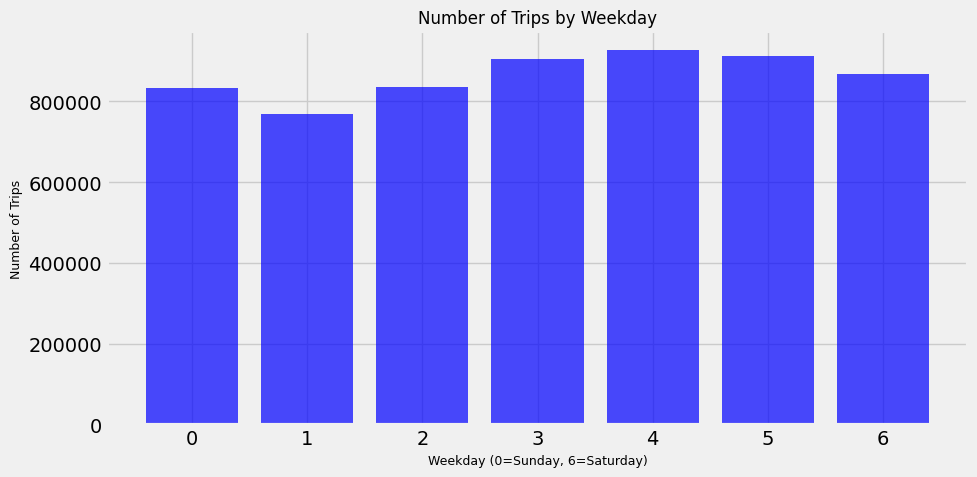

In [ ]:
# Group by pickup_weekday and count the number of trips
weekday_trip_count = df.groupBy("pickup_weekday").agg(F.count("pickup_weekday").alias("trip_count"))

# Order by pickup_weekday
weekday_trip_count = weekday_trip_count.orderBy("pickup_weekday")

# Convert to Pandas DataFrame for plotting
pandas_weekday_trip_count = weekday_trip_count.toPandas()

# Plot the results
plt.figure(figsize=(10, 5))

plt.bar(pandas_weekday_trip_count['pickup_weekday'], pandas_weekday_trip_count['trip_count'], color='b', alpha=0.7)

plt.title('Number of Trips by Weekday', fontsize=12)
plt.xlabel('Weekday (0=Sunday, 6=Saturday)', fontsize=9)
plt.ylabel('Number of Trips', fontsize=9)

plt.grid(True)
plt.tight_layout()
plt.show()

#### Visualize the number of trips occur in each hour throughout a day

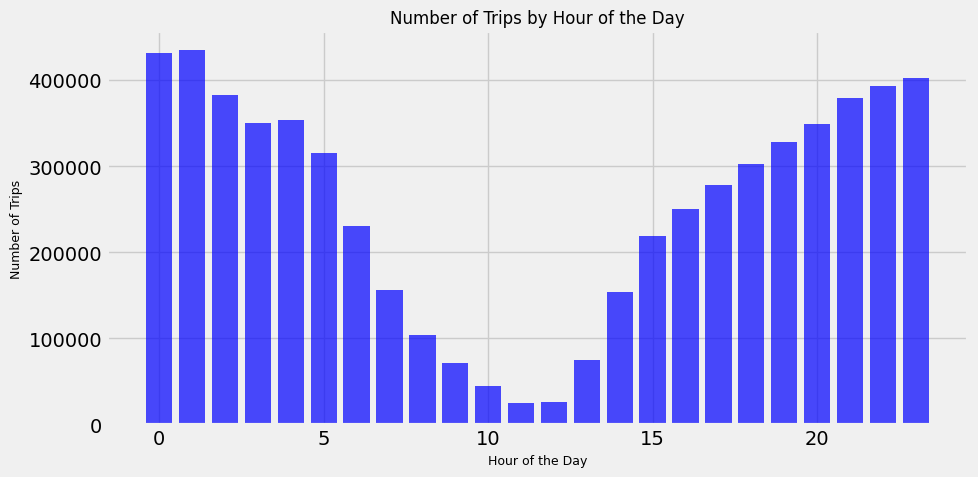

In [45]:
hourly_trip_count = df.groupBy("pickup_hour").agg(
    F.count("pickup_hour").alias("trip_count")
)

hourly_trip_count = hourly_trip_count.orderBy("pickup_hour")

pandas_hourly_trip_count = hourly_trip_count.toPandas()

plt.figure(figsize=(10, 5))

plt.bar(pandas_hourly_trip_count['pickup_hour'], pandas_hourly_trip_count['trip_count'], color='b', alpha=0.7)

plt.title('Number of Trips by Hour of the Day', fontsize=12)
plt.xlabel('Hour of the Day', fontsize=9)
plt.ylabel('Number of Trips', fontsize=9)

plt.grid(True)
plt.tight_layout() 
plt.show()


In [46]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+-----------+------------+------------+--------------+--------------+---------------+-------------+-----------+------------+------------------+---------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|congestion_surcharge|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|pickup_time|dropoff_date|dropoff_hour|dropoff_minute|dropoff_second|dropoff_weekday|dropoff_month|dropoff_day|dropoff_time|         speed_mph|trip_duration_minutes|
+--------+------

### Location

#### Borough having the most number of trips

In [47]:
pickup_borough_counts = df.groupBy("PU_Borough").count()
dropoff_borough_counts = df.groupBy("DO_Borough").count()

In [48]:
pickup_borough_counts_pd = pickup_borough_counts.toPandas()
dropoff_borough_counts_pd = dropoff_borough_counts.toPandas()

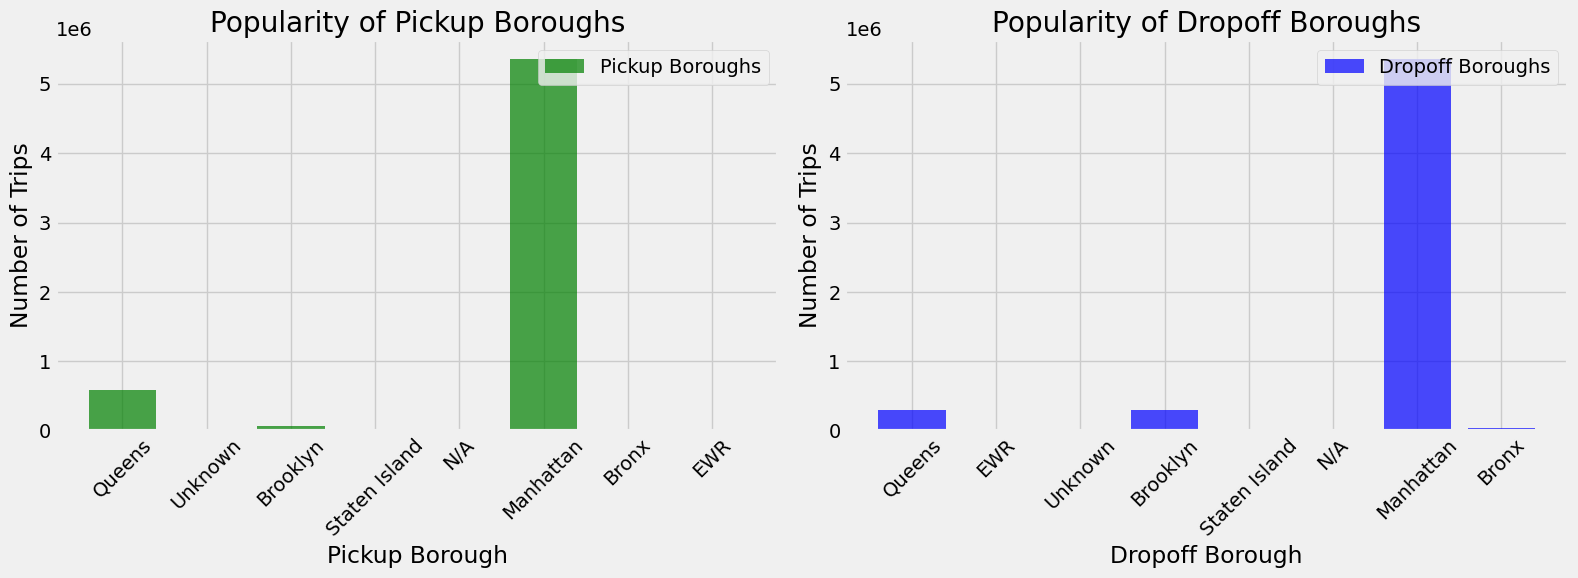

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].bar(pickup_borough_counts_pd['PU_Borough'], pickup_borough_counts_pd['count'], color='green', alpha=0.7, label='Pickup Boroughs')
ax[0].set_xlabel('Pickup Borough')
ax[0].set_ylabel('Number of Trips')
ax[0].set_title('Popularity of Pickup Boroughs')
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend(loc='upper right')

ax[1].bar(dropoff_borough_counts_pd['DO_Borough'], dropoff_borough_counts_pd['count'], color='blue', alpha=0.7, label='Dropoff Boroughs')
ax[1].set_xlabel('Dropoff Borough')
ax[1].set_ylabel('Number of Trips')
ax[1].set_title('Popularity of Dropoff Boroughs')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

### Checking the Covariance between Features

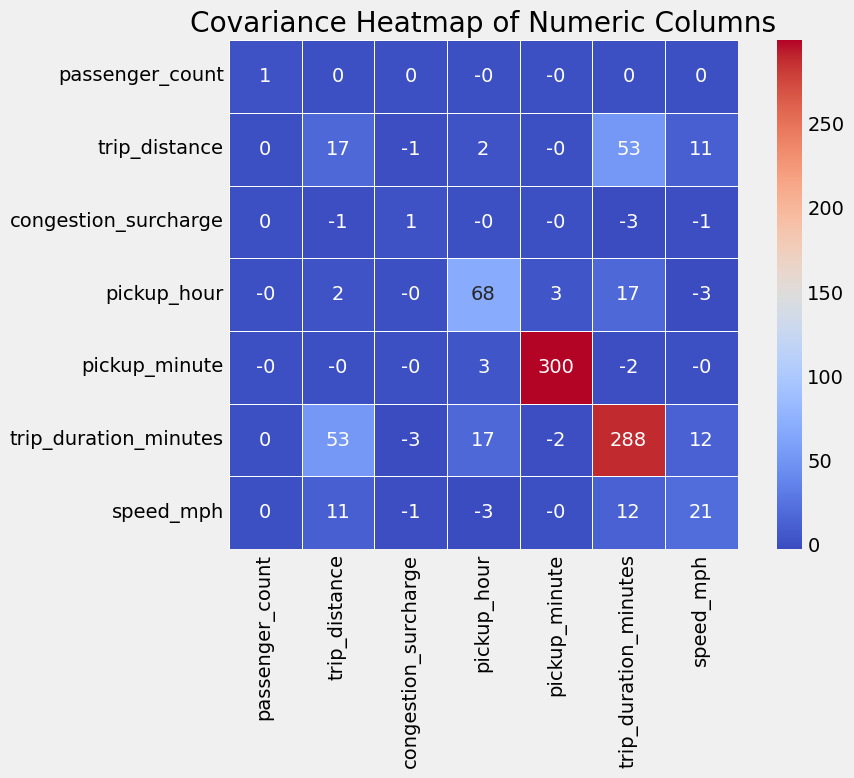

In [51]:
numeric_columns = [
    "passenger_count", "trip_distance", "congestion_surcharge",
    "pickup_hour", "pickup_minute", "trip_duration_minutes", "speed_mph"
]

numeric_df = df.select(numeric_columns).sample(fraction=0.1, seed=42).toPandas()

covariance_matrix = numeric_df.cov()

plt.figure(figsize=(10, 8))
sns.heatmap(
    covariance_matrix,
    annot=True, 
    cmap="coolwarm",
    fmt=".0f",  
    cbar=True,  
    square=True, 
    linewidths=0.5 
)
plt.title("Covariance Heatmap of Numeric Columns")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Adding Weather dataset


In [52]:
weather_data = pd.read_csv("../data/weather_data/merged_weather.csv")
weather_data.head(5)

,name,datetime,temp,humidity,precip,windgust,windspeed,winddir,cloudcover,visibility,severerisk,date,time,day,month,hour
0,"New York City,USA",2024-07-01 00:00:00,22.5,62.83,0.0,38.0,28.8,324,88.9,16.0,10,2024-07-01,00:00:00,1,7,0
1,"New York City,USA",2024-07-01 01:00:00,21.4,57.78,0.0,40.7,11.9,324,80.1,16.0,10,2024-07-01,01:00:00,1,7,1
2,"New York City,USA",2024-07-01 02:00:00,20.6,53.70,0.0,38.9,12.7,328,37.0,16.0,10,2024-07-01,02:00:00,1,7,2
3,"New York City,USA",2024-07-01 03:00:00,19.0,60.55,0.0,48.4,14.5,328,15.6,16.0,10,2024-07-01,03:00:00,1,7,3
4,"New York City,USA",2024-07-01 04:00:00,18.5,62.81,0.0,40.7,10.4,320,6.1,16.0,10,2024-07-01,04:00:00,1,7,4


In [53]:
weather_df = spark.createDataFrame(weather_data)

df = df.join(weather_df, (df['pickup_date'] == weather_df['date']) & (df['pickup_hour'] == weather_df['hour']), "left")

df = df.drop(weather_df['hour'])

df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------+------------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+-----------+------------+------------+--------------+--------------+---------------+-------------+-----------+------------+------------------+---------------------+-----------------+-------------------+----+--------+------+--------+---------+-------+----------+----------+----------+----------+--------+---+-----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|PULocationID|DOLocationID|congestion_surcharge|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|pickup_time|dropoff_date|dropoff

In [54]:
columns_to_drop = [
    'name', 'date', 'time', 'RatecodeID', 'vendorid', 'store_and_fwd_flag', 'date', 'month', 'time', 'date', 'datetime']

df = df.drop(*columns_to_drop)

df.show(5)

+--------------------+---------------------+---------------+-------------+------------+------------+--------------------+----------+--------------------+----------+--------------------+-------------+-----------+-----------+-------------+-------------+--------------+------------+----------+----------------+-----------+------------+------------+--------------+--------------+---------------+-------------+-----------+------------+------------------+---------------------+----+--------+------+--------+---------+-------+----------+----------+----------+---+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|PULocationID|DOLocationID|congestion_surcharge|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|enter_airport|pickup_date|pickup_hour|pickup_minute|pickup_second|pickup_weekday|pickup_month|pickup_day|pickup_week_hour|pickup_time|dropoff_date|dropoff_hour|dropoff_minute|dropoff_second|dropoff_weekday|dropoff_month|dropoff_day|dropoff_time|         spee

In [55]:
scatter = df[['precip']].sample(fraction=0.1, seed=42).toPandas()

In [56]:
trip_duration_seconds_pd = df.select("trip_duration_seconds").sample(fraction=0.1, seed=42).toPandas()

for i in scatter.columns:
    sns.scatterplot(x=scatter[i], y=trip_duration_seconds_pd['trip_duration_seconds'])
    plt.ylabel('Travel Duration (Seconds)')
    plt.show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `trip_duration_seconds` cannot be resolved. Did you mean one of the following? [`trip_duration_minutes`, `dropoff_second`, `pickup_second`, `trip_distance`, `DOLocationID`].;
'Project ['trip_duration_seconds]
+- Project [tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, dropoff_hour#2654, dropoff_minute#2680, ... 17 more fields]
   +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 24 more fields]
      +- Join LeftOuter, ((pickup_date#2449 = cast(date#4202 as date)) AND (cast(pickup_hour#2465 as bigint) = hour#4206L))
         :- Filter ((speed_mph#3513 >= -2.3861753333859337) AND (speed_mph#3513 <= 23.8390278544938))
         :  +- Filter ((speed_mph#3513 >= cast(0 as double)) AND (speed_mph#3513 <= cast(100 as double)))
         :     +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
         :        +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
         :           +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 10 more fields]
         :              +- Filter (trip_duration_seconds#3392L <= cast(72000 as bigint))
         :                 +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
         :                    +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 8 more fields]
         :                       +- Filter ((speed_mph#3212 >= cast(0 as double)) AND (speed_mph#3212 <= cast(100 as double)))
         :                          +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
         :                             +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 8 more fields]
         :                                +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
         :                                   +- Filter (trip_duration_seconds#3092L <= cast(72000 as bigint))
         :                                      +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
         :                                         +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 8 more fields]
         :                                            +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 9 more fields]
         :                                               +- Filter (trip_duration_seconds#2939L <= cast(72000 as bigint))
         :                                                  +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 8 more fields]
         :                                                     +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 7 more fields]
         :                                                        +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 6 more fields]
         :                                                           +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 5 more fields]
         :                                                              +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 4 more fields]
         :                                                                 +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 3 more fields]
         :                                                                    +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, ... 2 more fields]
         :                                                                       +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, dropoff_date#2629, hour(tpep_dropoff_datetime#2422, Some(Asia/Ho_Chi_Minh)) AS dropoff_hour#2654]
         :                                                                          +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, pickup_time#2605, to_date(tpep_dropoff_datetime#2422, None, Some(Asia/Ho_Chi_Minh), false) AS dropoff_date#2629]
         :                                                                             +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, pickup_week_hour#2582, concat(lpad(cast(pickup_hour#2465 as string), 2, 0), :, lpad(cast(pickup_minute#2482 as string), 2, 0), :, lpad(cast(pickup_second#2500 as string), 2, 0)) AS pickup_time#2605]
         :                                                                                +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, pickup_day#2560, ((pickup_weekday#2519 * 24) + pickup_hour#2465) AS pickup_week_hour#2582]
         :                                                                                   +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, pickup_month#2539, day(cast(tpep_pickup_datetime#2407 as date)) AS pickup_day#2560]
         :                                                                                      +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, pickup_weekday#2519, month(cast(tpep_pickup_datetime#2407 as date)) AS pickup_month#2539]
         :                                                                                         +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, pickup_second#2500, (dayofweek(cast(tpep_pickup_datetime#2407 as date)) - 1) AS pickup_weekday#2519]
         :                                                                                            +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, pickup_minute#2482, second(tpep_pickup_datetime#2407, Some(Asia/Ho_Chi_Minh)) AS pickup_second#2500]
         :                                                                                               +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, pickup_hour#2465, minute(tpep_pickup_datetime#2407, Some(Asia/Ho_Chi_Minh)) AS pickup_minute#2482]
         :                                                                                                  +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, pickup_date#2449, hour(tpep_pickup_datetime#2407, Some(Asia/Ho_Chi_Minh)) AS pickup_hour#2465]
         :                                                                                                     +- Project [VendorID#38, tpep_pickup_datetime#2407, tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370, to_date(tpep_pickup_datetime#2407, None, Some(Asia/Ho_Chi_Minh), false) AS pickup_date#2449]
         :                                                                                                        +- Project [VendorID#38, tpep_pickup_datetime#2407, to_timestamp(tpep_dropoff_datetime#40, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Asia/Ho_Chi_Minh), false) AS tpep_dropoff_datetime#2422, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370]
         :                                                                                                           +- Project [VendorID#38, to_timestamp(tpep_pickup_datetime#39, Some(yyyy-MM-dd HH:mm:ss), TimestampType, Some(Asia/Ho_Chi_Minh), false) AS tpep_pickup_datetime#2407, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370]
         :                                                                                                              +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, enter_airport#2370]
         :                                                                                                                 +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669, CASE WHEN (airport_fee#56 > cast(0 as double)) THEN 1 ELSE 0 END AS enter_airport#2370]
         :                                                                                                                    +- Filter NOT cast(passenger_count#41L as bigint) IN (cast(7 as bigint),cast(8 as bigint),cast(9 as bigint),cast(0 as bigint))
         :                                                                                                                       +- Filter (((trip_distance#42 >= -862.5743383000328) AND (trip_distance#42 <= 873.167473642823)) AND (trip_distance#42 >= cast(1 as double)))
         :                                                                                                                          +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, PULocationID#45, DOLocationID#46, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, DO_Borough#642, DO_Zone#669]
         :                                                                                                                             +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, PU_service_zone#446, DO_Borough#642, DO_Zone#669, DO_service_zone#696]
         :                                                                                                                                +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, PU_service_zone#446, LocationID#585, DO_Borough#642, ... 2 more fields]
         :                                                                                                                                   +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, PU_service_zone#446, LocationID#585, DO_Borough#642, ... 2 more fields]
         :                                                                                                                                      +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, PU_service_zone#446, LocationID#585, Borough#586 AS DO_Borough#642, ... 2 more fields]
         :                                                                                                                                         +- Join Inner, (DOLocationID#46 = LocationID#585)
         :                                                                                                                                            :- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, PU_Borough#398, PU_Zone#422, PU_service_zone#446]
         :                                                                                                                                            :  +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, LocationID#322, PU_Borough#398, PU_Zone#422, service_zone#325 AS PU_service_zone#446]
         :                                                                                                                                            :     +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, LocationID#322, PU_Borough#398, Zone#324 AS PU_Zone#422, service_zone#325]
         :                                                                                                                                            :        +- Project [VendorID#38, tpep_pickup_datetime#39, tpep_dropoff_datetime#40, passenger_count#41L, trip_distance#42, RatecodeID#43L, store_and_fwd_flag#44, PULocationID#45, DOLocationID#46, payment_type#47L, fare_amount#48, extra#49, mta_tax#50, tip_amount#51, tolls_amount#52, improvement_surcharge#53, total_amount#54, congestion_surcharge#55, Airport_fee#56, LocationID#322, Borough#323 AS PU_Borough#398, Zone#324, service_zone#325]
         :                                                                                                                                            :           +- Join Inner, (PULocationID#45 = LocationID#322)
         :                                                                                                                                            :              :- Union false, false
         :                                                                                                                                            :              :  :- Relation [VendorID#38,tpep_pickup_datetime#39,tpep_dropoff_datetime#40,passenger_count#41L,trip_distance#42,RatecodeID#43L,store_and_fwd_flag#44,PULocationID#45,DOLocationID#46,payment_type#47L,fare_amount#48,extra#49,mta_tax#50,tip_amount#51,tolls_amount#52,improvement_surcharge#53,total_amount#54,congestion_surcharge#55,Airport_fee#56] parquet
         :                                                                                                                                            :              :  :- Relation [VendorID#76,tpep_pickup_datetime#77,tpep_dropoff_datetime#78,passenger_count#79L,trip_distance#80,RatecodeID#81L,store_and_fwd_flag#82,PULocationID#83,DOLocationID#84,payment_type#85L,fare_amount#86,extra#87,mta_tax#88,tip_amount#89,tolls_amount#90,improvement_surcharge#91,total_amount#92,congestion_surcharge#93,Airport_fee#94] parquet
         :                                                                                                                                            :              :  +- Relation [VendorID#114,tpep_pickup_datetime#115,tpep_dropoff_datetime#116,passenger_count#117L,trip_distance#118,RatecodeID#119L,store_and_fwd_flag#120,PULocationID#121,DOLocationID#122,payment_type#123L,fare_amount#124,extra#125,mta_tax#126,tip_amount#127,tolls_amount#128,improvement_surcharge#129,total_amount#130,congestion_surcharge#131,Airport_fee#132] parquet
         :                                                                                                                                            :              +- Relation [LocationID#322,Borough#323,Zone#324,service_zone#325] csv
         :                                                                                                                                            +- Relation [LocationID#585,Borough#586,Zone#587,service_zone#588] csv
         +- LogicalRDD [name#4191, datetime#4192, temp#4193, humidity#4194, precip#4195, windgust#4196, windspeed#4197, winddir#4198L, cloudcover#4199, visibility#4200, severerisk#4201L, date#4202, time#4203, day#4204L, month#4205L, hour#4206L], false


base on the visualization we can drop column snow_fall and snow_depth because observing no noticeable trend or infomation

In [ ]:
df = df.drop('snow_fall', 'snow_depth')

#### Relationship between Day Temperature and Number of Trips

In [ ]:
# import plotly.graph_objects as go

# grouped_data = (
#     df.groupBy("pickup_month", "pickup_day")
#     .agg(
#         F.avg("average_temperature").alias("avg_temperature"),
#         F.count("pickup_day").alias("trip_count")
#     )
#     .orderBy("pickup_month", "pickup_day")
#     .toPandas()
# )

# month_names = {7: "July", 8: "August", 9: "September"}
# for month in [7, 8, 9]:
#     month_data = grouped_data[grouped_data["pickup_month"] == month]
    
#     fig = go.Figure()

#     fig.add_trace(go.Scatter(
#         x=month_data['pickup_day'],
#         y=month_data['avg_temperature'],
#         mode='lines',
#         line=dict(color='orange', width=2),
#         name='Average Temperature'
#     ))

#     fig.add_trace(go.Scatter(
#         x=month_data['pickup_day'],
#         y=month_data['trip_count'],
#         mode='lines',
#         line=dict(color='blue', width=2),
#         name='Trip Count',
#         yaxis='y2'  # Use secondary y-axis
#     ))

#     fig.update_layout(
#         title=f"Trip Count and Average Temperature in {month_names[month]}",
#         xaxis=dict(title="Day of Month"),
#         yaxis=dict(title="Average Temperature (°C)", side="left"),
#         yaxis2=dict(title="Trip Count", overlaying='y', side="right"),
#         legend=dict(title="Legend"),
#         template="plotly_white"
#     )

#     fig.show()


#### Relationship between `prepcipitation` and `trip_count` vs `trip_duration`

In [ ]:
# import plotly.graph_objects as go

# precipitation_data = (
#     df.groupBy("precipitation")
#     .agg(
#         F.count("pickup_day").alias("trip_count"),
#         F.avg("trip_duration_seconds").alias("avg_trip_duration")
#     )
#     .orderBy("precipitation")
#     .toPandas()
# )

# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=precipitation_data['precipitation'],
#     y=precipitation_data['trip_count'],
#     mode='lines+markers',
#     line=dict(color='blue', width=2),
#     name='Trip Count'
# ))

# fig.add_trace(go.Scatter(
#     x=precipitation_data['precipitation'],
#     y=precipitation_data['avg_trip_duration'],
#     mode='lines+markers',
#     line=dict(color='orange', width=2, dash='dot'),
#     name='Avg Trip Duration',
#     yaxis='y2'  
# ))

# fig.update_layout(
#     title="Relationship Between Precipitation, Trip Count, and Avg Trip Duration",
#     xaxis=dict(title="Precipitation (mm)"),
#     yaxis=dict(title="Trip Count", side="left"),
#     yaxis2=dict(title="Avg Trip Duration (seconds)", overlaying='y', side="right"),
#     legend=dict(title="Legend"),
#     template="plotly_white"
# )

# fig.show()


* People avoid trips during rainy weather unless necessary, as reflected in the trip count. The sharp drop in trip count supports this behavioral trend.
* Longer average trip durations in rainy conditions indicate potential traffic congestion, slower driving speeds, or more cautious travel during rain.
* The slight increase in trip count for higher precipitation levels might indicate that some trips are unavoidable, regardless of weather conditions.

### Understanding the congestion trends in each Zone in NYC

In [57]:
df.select('congestion_surcharge').distinct().show()

+--------------------+
|congestion_surcharge|
+--------------------+
|                 0.0|
|                 2.5|
|                -2.5|
+--------------------+



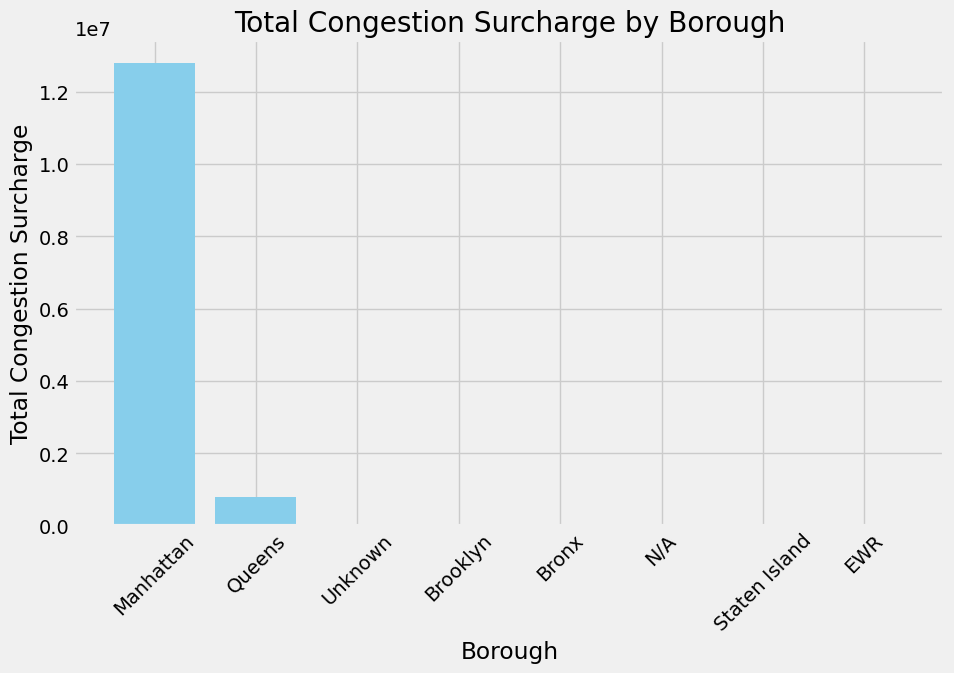

In [58]:
borough_surcharge_spark = df.groupBy("PU_Borough").agg(F.sum("congestion_surcharge").alias("Total_Surcharge"))

borough_surcharge_spark = borough_surcharge_spark.orderBy(F.desc("Total_Surcharge"))

borough_surcharge_pandas = borough_surcharge_spark.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(borough_surcharge_pandas['PU_Borough'], borough_surcharge_pandas['Total_Surcharge'], color='skyblue')
plt.title('Total Congestion Surcharge by Borough')
plt.xlabel('Borough')
plt.ylabel('Total Congestion Surcharge')
plt.xticks(rotation=45)
plt.show()


##### Convert `congestion_surcharge` to `congestion_level` 

In [59]:
low_threshold = -2.5  
high_threshold = 2.5

df = df.withColumn(
    "congestion_level",
    F.when(df["congestion_surcharge"] <= low_threshold, "Low")
     .when((df["congestion_surcharge"] > low_threshold) & (df["congestion_surcharge"] < high_threshold), "Medium")
     .otherwise("High")
)

df.select("congestion_surcharge", "congestion_level").show()


+--------------------+----------------+
|congestion_surcharge|congestion_level|
+--------------------+----------------+
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 0.0|          Medium|
|                 0.0|          Medium|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 0.0|          Medium|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
|                 2.5|            High|
+--------------------+----------------+
only showing top 20 rows



##### `PU_Zone` that has High `congestion_level`

In [60]:
high_congestion_zones = df.filter(F.col("congestion_level") == "High") \
    .groupBy("PU_Zone", "PU_Borough") \
    .count() \
    .orderBy(F.desc("count"))

high_congestion_zones.show(10, truncate=False)

+----------------------------+----------+------+
|PU_Zone                     |PU_Borough|count |
+----------------------------+----------+------+
|Midtown Center              |Manhattan |287204|
|Upper East Side South       |Manhattan |240336|
|Penn Station/Madison Sq West|Manhattan |239569|
|Midtown East                |Manhattan |221724|
|Upper East Side North       |Manhattan |219764|
|Times Sq/Theatre District   |Manhattan |202887|
|East Chelsea                |Manhattan |188533|
|Lincoln Square East         |Manhattan |184708|
|Murray Hill                 |Manhattan |176690|
|Midtown North               |Manhattan |168851|
+----------------------------+----------+------+
only showing top 10 rows



### Final Touch the Dataset

In [61]:
# Convert 'precipitation' to 'rain' (0 or 1)
df = df.withColumn("rain", F.when(df["precip"] > 0, 1).otherwise(0))

# Convert 'congestion_level' to 0, 1, or 2 (low, medium, high -> 0, 1, 2)
df = df.withColumn("congestion_level", 
                   F.when(df["congestion_level"] == "Low", 0)
                   .when(df["congestion_level"] == "Medium", 1)
                   .when(df["congestion_level"] == "High", 2)
                   .otherwise(-1))  # or set it to None if needed

# Show the updated dataframe with the transformed columns
df.select("precip", "rain", "enter_airport", "congestion_level").show(truncate=False)

# Drop unnecessary columns
df = df.drop('tpep_pickup_datetime', 'tpep_dropoff_datetime', 'congestion_surcharge', 'maximum_temperature', 'minimum_temperature')


+------+----+-------------+----------------+
|precip|rain|enter_airport|congestion_level|
+------+----+-------------+----------------+
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |1            |1               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |1            |2               |
|0.0   |0   |1            |2               |
|0.0   |0   |0            |2               |
|0.0   |0   |0            |2               |
|0.0   |0 

In [62]:


def missing_ratio_spark(df):
    total_rows = df.count()

    missing_counts = []
    for column in df.columns:
        if dict(df.dtypes)[column] in ['float', 'double']:
            missing_count = df.filter(F.col(column).isNull() | F.isnan(column)).count()
        else:
            missing_count = df.filter(F.col(column).isNull()).count()
        
        missing_ratio = (missing_count / total_rows) * 100
        missing_counts.append((column, missing_ratio))
    
    missing_data_df = spark.createDataFrame(missing_counts, ["column_name", "missing_ratio"])

    missing_data_df = missing_data_df.orderBy(F.col("missing_ratio"), ascending=False)

    #missing_data_df = missing_data_df.filter(F.col("missing_ratio") > 0)
    
    return missing_data_df

missing_data = missing_ratio_spark(df)
missing_data.show()


+--------------------+------------------+
|         column_name|     missing_ratio|
+--------------------+------------------+
|          visibility|0.4578411367600857|
|                temp|0.4578411367600857|
|              precip|0.4578411367600857|
|            humidity|0.4578411367600857|
|          severerisk|0.4578411367600857|
|            windgust|0.4578411367600857|
|                 day|0.4578411367600857|
|           windspeed|0.4578411367600857|
|             winddir|0.4578411367600857|
|          cloudcover|0.4578411367600857|
|             PU_Zone|               0.0|
|        dropoff_time|               0.0|
|          DO_Borough|               0.0|
|         pickup_hour|               0.0|
|             DO_Zone|               0.0|
|           speed_mph|               0.0|
|       enter_airport|               0.0|
|          pickup_day|               0.0|
|         pickup_date|               0.0|
|trip_duration_min...|               0.0|
+--------------------+------------

# Feature selection

### Calculate correlation matrix

In [63]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Select numeric columns from the original DataFrame
numeric_columns = [
    "passenger_count", "trip_distance", "congestion_level", "PULocationID", "DOLocationID",
    "pickup_hour", "pickup_minute", "dropoff_minute", "trip_duration_minutes",
    "speed_mph", "visibility", "windspeed", "winddir",
    "temp", "precip", "humidity", "severerisk", "windgust", "day", "cloudcover", "rain"
]

# Sample the DataFrame to reduce size (10% sample in this case)
sampled_df = df.select(numeric_columns).sample(fraction=0.1, seed=42)

# Assemble the numeric columns into a single vector column
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features", handleInvalid="skip")
assembled_df = assembler.transform(sampled_df)

# Calculate the Pearson correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features", method="pearson")



24/12/09 11:12:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/09 11:12:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


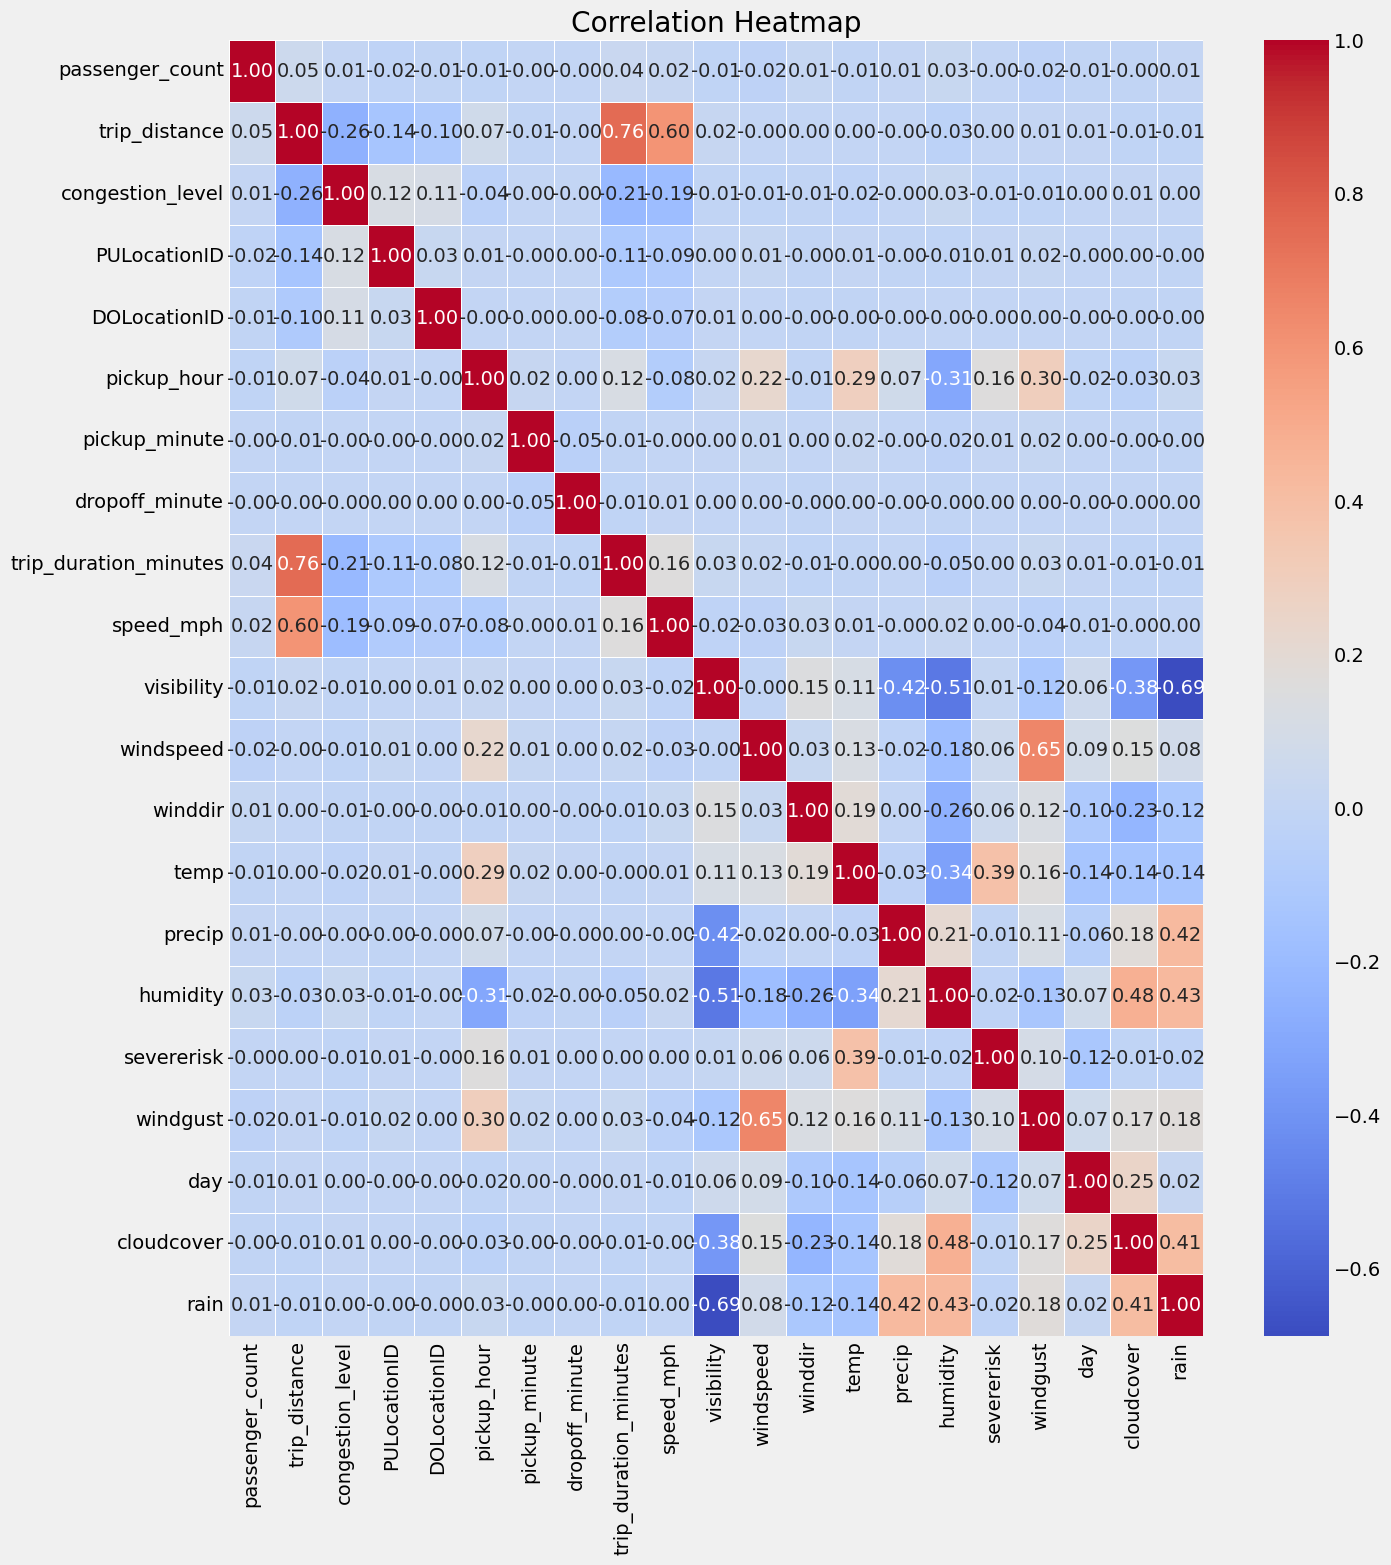

In [64]:
# Convert the correlation matrix to a Pandas DataFrame (optional)
corr_matrix_spark = correlation_matrix.head()[0]  # Extract the matrix
corr_matrix_pd = pd.DataFrame(corr_matrix_spark.toArray(), columns=numeric_columns, index=numeric_columns)


plt.figure(figsize=(14, 16))  # Set the figure size
sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add a title for the heatmap
plt.title("Correlation Heatmap")
plt.show()


### Slipt data divide 2 part: high_corr and low_corr

In [65]:
correlation_with_target = corr_matrix_pd["trip_duration_minutes"]

# Set threshold for high and low correlation
threshold = 0.1

# Split features into high and low correlation groups
high_corr_features = correlation_with_target[correlation_with_target.abs() >= threshold].index.tolist()
low_corr_features = correlation_with_target[correlation_with_target.abs() < threshold].index.tolist()

print("High Correlation Features:", high_corr_features)
print("Low Correlation Features:", low_corr_features)


High Correlation Features: ['trip_distance', 'congestion_level', 'PULocationID', 'pickup_hour', 'trip_duration_minutes', 'speed_mph']
Low Correlation Features: ['passenger_count', 'DOLocationID', 'pickup_minute', 'dropoff_minute', 'visibility', 'windspeed', 'winddir', 'temp', 'precip', 'humidity', 'severerisk', 'windgust', 'day', 'cloudcover', 'rain']


In [66]:
# Subset with high correlation features
subset_high_corr = df.select(high_corr_features).sample(fraction=0.1, seed=42)

# Subset with low correlation features
subset_low_corr = df.select(low_corr_features).sample(fraction=0.1, seed=42)
print("Subset with High Correlation Features:")
subset_high_corr.show(5)

print("Subset with Low Correlation Features:")
subset_low_corr.show(5)


Subset with High Correlation Features:
+-------------+----------------+------------+-----------+---------------------+------------------+
|trip_distance|congestion_level|PULocationID|pickup_hour|trip_duration_minutes|         speed_mph|
+-------------+----------------+------------+-----------+---------------------+------------------+
|         3.34|               2|         230|          7|   14.266666666666667|14.046728971962615|
|          2.9|               2|         100|          7|   17.083333333333332|10.185365853658537|
|         1.33|               2|         229|          7|    9.383333333333333| 8.504440497335702|
|         3.91|               2|         186|          7|                20.45|11.471882640586799|
|         1.79|               2|         249|          7|                 12.0|              8.95|
+-------------+----------------+------------+-----------+---------------------+------------------+
only showing top 5 rows

Subset with Low Correlation Features:


+---------------+------------+-------------+--------------+----------+---------+-------+----+------+--------+----------+--------+---+----------+----+
|passenger_count|DOLocationID|pickup_minute|dropoff_minute|visibility|windspeed|winddir|temp|precip|humidity|severerisk|windgust|day|cloudcover|rain|
+---------------+------------+-------------+--------------+----------+---------+-------+----+------+--------+----------+--------+---+----------+----+
|              1|          83|           48|             6|      16.0|     24.3|      1|26.7|   0.0|   43.34|        10|    47.8|  1|      19.2|   0|
|              1|         163|           49|            54|      16.0|     24.3|      1|26.7|   0.0|   43.34|        10|    47.8|  1|      19.2|   0|
|              1|         229|           56|             1|      16.0|     24.3|      1|26.7|   0.0|   43.34|        10|    47.8|  1|      19.2|   0|
|              1|         234|           57|             5|      16.0|     24.3|      1|26.7|   0.0|

### Calculate VIF 

In [67]:
from pyspark.ml.regression import LinearRegression

# Function to calculate VIF
def calculate_vif(df, features):
    vif_values = []
    for feature in features:
        # Exclude the current feature from predictors
        predictors = [col for col in features if col != feature]
        assembler = VectorAssembler(inputCols=predictors, outputCol="features", handleInvalid="skip")
        assembled_df = assembler.transform(df.select(predictors + [feature]))
        
        # Fit a linear regression model
        lr = LinearRegression(featuresCol="features", labelCol=feature)
        lr_model = lr.fit(assembled_df)
        
        # Calculate R-squared and VIF
        r2 = lr_model.summary.r2
        vif = 1 / (1 - r2) if r2 < 1 else float("inf")  # Avoid division by zero
        vif_values.append((feature, vif))
    
    return pd.DataFrame(vif_values, columns=["Feature", "VIF"])

# Calculate VIF for high correlation subset
high_corr_features = [f for f in high_corr_features if f != "trip_duration_minutes"]  # Exclude target
vif_high_corr = calculate_vif(subset_high_corr, high_corr_features)

print("VIF for High Correlation Subset:")
print(vif_high_corr)

# Calculate VIF for low correlation subset
low_corr_features = [f for f in low_corr_features if f != "trip_duration_minutes"]  # Exclude target
vif_low_corr = calculate_vif(subset_low_corr, low_corr_features)

print("VIF for Low Correlation Subset:")
print(vif_low_corr)


24/12/09 11:12:24 WARN Instrumentation: [ce0d89b9] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:12:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/12/09 11:12:32 WARN Instrumentation: [3a01797b] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:12:40 WARN Instrumentation: [c14ea39c] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:12:47 WARN Instrumentation: [4d1f729e] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:12:54 WARN Instrumentation: [e46c17e9] regParam is zero, which might cause numerical instability and overfitting.


VIF for High Correlation Subset:
            Feature       VIF
0     trip_distance  1.669879
1  congestion_level  1.081675
2      PULocationID  1.027048
3       pickup_hour  1.030190
4         speed_mph  1.612686


24/12/09 11:13:03 WARN Instrumentation: [2ed54b7e] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:08 WARN Instrumentation: [78e96887] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:16 WARN Instrumentation: [f54e3535] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:23 WARN Instrumentation: [985541bc] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:32 WARN Instrumentation: [8310c998] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:40 WARN Instrumentation: [f26418b8] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:47 WARN Instrumentation: [d83ed59e] regParam is zero, which might cause numerical instability and overfitting.
24/12/09 11:13:56 WARN Instrumentation: [6f94fcd1] regParam is zero, which might cause numerical instability and overf

VIF for Low Correlation Subset:
            Feature       VIF
0   passenger_count  1.001901
1      DOLocationID  1.000133
2     pickup_minute  1.003272
3    dropoff_minute  1.002104
4        visibility  2.304017
5         windspeed  1.849198
6           winddir  1.134168
7              temp  1.385423
8            precip  1.287839
9          humidity  1.925789
10       severerisk  1.211810
11         windgust  1.922949
12              day  1.135265
13       cloudcover  1.595554
14             rain  2.114870


### Drop column with low VIF

In [68]:
df = df.drop('passenger_count','pickup_minute','dropoff_minute','windspeed','winddir','temp','precip',' severerisk',' day','cloudcover' )

### Calculate correlation matrix after drop

In [70]:
# Select numeric columns from the original DataFrame
numeric_columns_1 = [
     "trip_distance", "congestion_level", "PULocationID", "DOLocationID", 
     "trip_duration_minutes","speed_mph", "visibility", "humidity", "windgust","rain","pickup_hour"
]

# Sample the DataFrame to reduce size (10% sample in this case)
sampled_df_1= df.select(numeric_columns_1).sample(fraction=0.1, seed=42)

# Assemble the numeric columns into a single vector column
assembler_1= VectorAssembler(inputCols=numeric_columns_1, outputCol="features", handleInvalid="skip")
assembled_df_1 = assembler_1.transform(sampled_df_1)

# Calculate the Pearson correlation matrix
correlation_matrix_1 = Correlation.corr(assembled_df_1, "features", method="pearson")



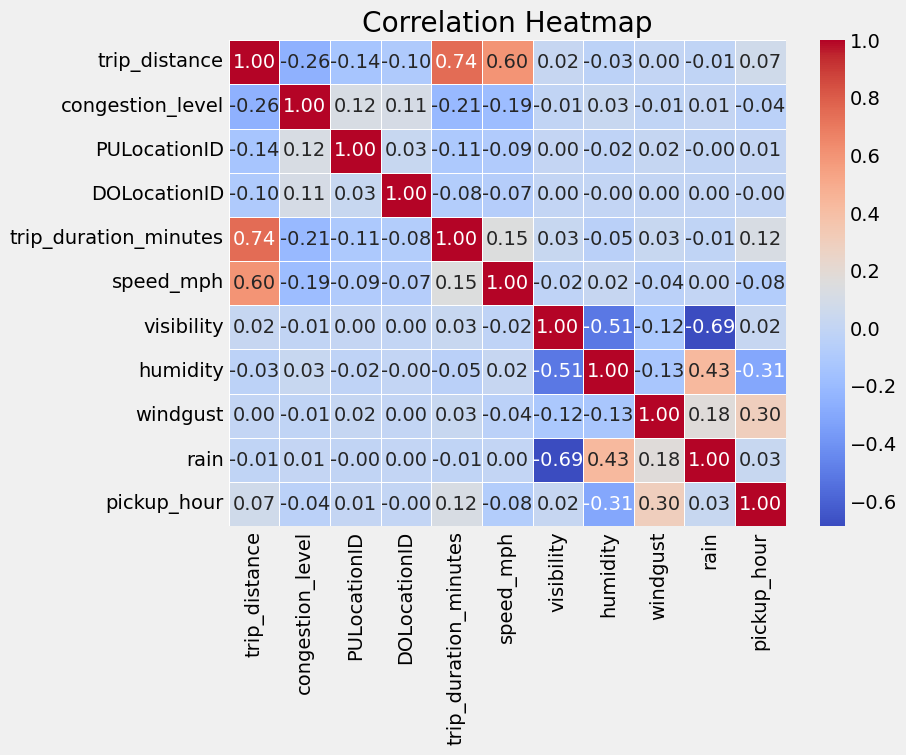

In [72]:
# Convert the correlation matrix to a Pandas DataFrame (optional)
corr_matrix_spark_1 = correlation_matrix_1.head()[0]  # Extract the matrix
corr_matrix_pd_1= pd.DataFrame(corr_matrix_spark_1.toArray(), columns=numeric_columns_1, index=numeric_columns_1)


plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(corr_matrix_pd_1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add a title for the heatmap
plt.title("Correlation Heatmap")
plt.show()


In [88]:
df = df.drop("PU_Borough","DO_Borough","pickup_date","day","enter_airport","pickup_date","dropoff_date","pickup_time","dropoff_time","dropoff_weekday","pickup_weekday","pickup_second","dropoff_second",
             "pickup_month","dropoff_month","pickup_day","dropoff_day","PU_Zone","DO_Zone","pickup_week_hour","dropoff_hour","severerisk")

In [95]:
df.coalesce(1).write.csv("../data/dataset.csv", header=True, mode = "overwrite")